### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_4/v1_hospital_visits/alabama/2022_09_19_17_11_59/

__pycache__/   keyspace.yaml             output.hdf
branches.yaml  logs/                     requirements.txt
count_data/    model_specification.yaml  settings.py


In [3]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_4/v1_hospital_visits/alabama/2022_09_19_17_11_59/count_data

deaths.csv             population.csv          state_person_time.csv  ylds.csv
deaths.hdf             population.hdf          state_person_time.hdf  ylds.hdf
healthcare_visits.csv  risk_exposure_time.csv  transition_count.csv   ylls.csv
healthcare_visits.hdf  risk_exposure_time.hdf  transition_count.hdf   ylls.hdf


In [4]:
sim_results_dir = '/mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_4/v1_hospital_visits/alabama/2022_09_19_17_11_59/count_data/'

### Exploring Data

In [5]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,1


In [6]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [7]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [8]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

102149225.8234086

In [9]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

102149225.82340862

### Total DALYs by Year

In [10]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,1681.272527,29.176925,1710.449451
1,female,25_to_29,29,2024,2468.972006,27.886714,2496.858720
2,female,25_to_29,29,2025,1908.894542,28.026406,1936.920948
3,female,25_to_29,29,2026,2530.268365,28.211406,2558.479771
4,female,25_to_29,29,2027,1961.958976,27.684770,1989.643747


In [11]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,6015.727327,763.214967,12920.395674
1,2024,6164.483535,774.071863,13066.953222
2,2025,6154.821905,856.739556,13196.642138
3,2026,6218.999249,855.523618,13426.763681
4,2027,6278.746609,927.975327,13454.836739


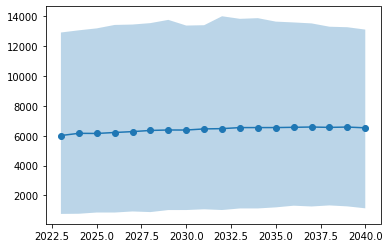

In [12]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [13]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,5.350000,0.0,31.050
1,25_to_29,female,2024,5.983333,0.0,35.050
2,25_to_29,female,2025,5.083333,0.0,30.050
3,25_to_29,female,2026,5.333333,0.0,35.525
4,25_to_29,female,2027,5.400000,0.0,32.625


In [14]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model4vv_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [15]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27465.374401
1,25_to_29,female,2023,232,27790.258727
2,25_to_29,female,2023,357,27624.366872
3,25_to_29,female,2023,394,27459.318275
4,25_to_29,female,2023,602,27431.260780


In [16]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001165,0.000902,0.001599
1,25_to_29,female,2024,0.001317,0.000973,0.001652
2,25_to_29,female,2025,0.001129,0.000899,0.001464
3,25_to_29,female,2026,0.001190,0.000762,0.001643
4,25_to_29,female,2027,0.001210,0.000821,0.001541


In [17]:
%%capture 
with PdfPages('model4vv_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [18]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model4vv_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [19]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
1,6,25_to_29,female,2024,acute_ischemic_stroke,0.0,0.0,0.000
2,12,25_to_29,female,2025,acute_ischemic_stroke,0.1,0.0,0.775
3,18,25_to_29,female,2026,acute_ischemic_stroke,0.0,0.0,0.000
4,24,25_to_29,female,2027,acute_ischemic_stroke,0.0,0.0,0.000


In [20]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,6,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,12,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,18,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,24,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [21]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000004,0.0,0.000028
1,25_to_29,female,2024,0.000000,0.0,0.000000
2,25_to_29,female,2025,0.000004,0.0,0.000029
3,25_to_29,female,2026,0.000000,0.0,0.000000
4,25_to_29,female,2027,0.000000,0.0,0.000000


In [22]:
%%capture 
with PdfPages('model4vv_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [23]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.010189,0.003620,0.012678
537,95_plus,male,2038,0.010520,0.002879,0.021467
538,95_plus,male,2039,0.009674,0.005948,0.015072
539,95_plus,male,2040,0.008230,0.001654,0.013889


In [24]:
%%capture
with PdfPages('model4vv_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [25]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction', 'angina',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [26]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000134,0.000044,0.000293
1,25_to_29,female,2024,0.000154,0.000073,0.000353
2,25_to_29,female,2025,0.000115,0.000008,0.000249
3,25_to_29,female,2026,0.000115,0.000037,0.000215
4,25_to_29,female,2027,0.000112,0.000008,0.000265


In [27]:
%%capture
with PdfPages('model4vv_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [28]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000047,0.000000,0.000109
1,25_to_29,female,2024,0.000070,0.000008,0.000138
2,25_to_29,female,2025,0.000063,0.000037,0.000139
3,25_to_29,female,2026,0.000078,0.000000,0.000148
4,25_to_29,female,2027,0.000071,0.000008,0.000141


In [29]:
%%capture
with PdfPages('model4vv_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [30]:
%%capture
with PdfPages('model4vv_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Angina

In [31]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate_summ = (angina_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

angina_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000040,0.0,0.000101
1,25_to_29,female,2024,0.000051,0.0,0.000139
2,25_to_29,female,2025,0.000041,0.0,0.000131
3,25_to_29,female,2026,0.000022,0.0,0.000066
4,25_to_29,female,2027,0.000045,0.0,0.000112


In [32]:
%%capture
with PdfPages('model4vv_angina_csmr.pdf') as pdf:
    for sex in angina_rate_summ.sex.unique():
        for year in angina_rate_summ.year.unique():
            plt.figure() 
            subdata = angina_rate_summ.loc[(angina_rate_summ.sex==sex) & (angina_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [33]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.032720,0.000000,0.084850
1,25_to_29,female,2024,0.047156,0.005000,0.096041
2,25_to_29,female,2025,0.041387,0.023025,0.088864
3,25_to_29,female,2026,0.047829,0.000000,0.091196
4,25_to_29,female,2027,0.044925,0.004651,0.103027


In [34]:
%%capture
with PdfPages('model4vv_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [35]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000013,5.565167e-06,0.000024
1,25_to_29,female,2024,0.000013,3.450817e-06,0.000033
2,25_to_29,female,2025,0.000011,6.343442e-07,0.000029
3,25_to_29,female,2026,0.000010,2.835558e-06,0.000020
4,25_to_29,female,2027,0.000011,6.444720e-07,0.000024


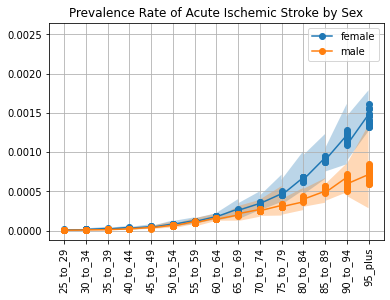

In [36]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [37]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

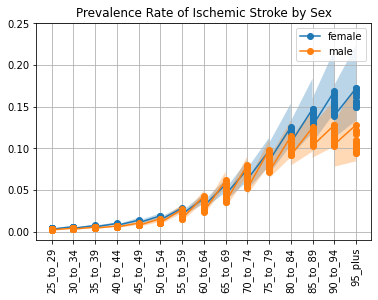

In [38]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [39]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000050,0.000024,0.000093
1,25_to_29,female,2024,0.000052,0.000026,0.000110
2,25_to_29,female,2025,0.000047,0.000019,0.000081
3,25_to_29,female,2026,0.000046,0.000033,0.000060
4,25_to_29,female,2027,0.000043,0.000016,0.000065


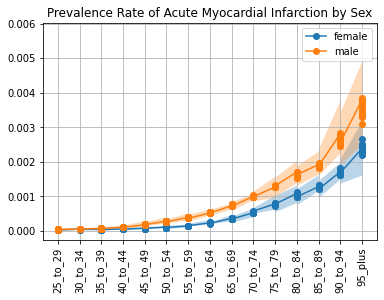

In [40]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [41]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001514,0.001211,0.001852
1,25_to_29,female,2024,0.001520,0.001125,0.001905
2,25_to_29,female,2025,0.001513,0.001180,0.001914
3,25_to_29,female,2026,0.001650,0.001265,0.002107
4,25_to_29,female,2027,0.001658,0.001079,0.002189


In [42]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Angina

In [43]:
prev_angina = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
prev_angina = prev_angina.rename(columns = {'ptvalue':'value'})
prev_angina = pd.concat([prev_angina, per_time_group.ptvalue], axis=1)
prev_angina['rate']= prev_angina['value'] / prev_angina['ptvalue']
prev_angina_summ = (prev_angina
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000185,0.000035,0.000305
1,25_to_29,female,2024,0.000169,0.000021,0.000357
2,25_to_29,female,2025,0.000167,0.000075,0.000308
3,25_to_29,female,2026,0.000183,0.000090,0.000312
4,25_to_29,female,2027,0.000157,0.000084,0.000289


In [44]:
%%capture
for sex in prev_angina_summ.sex.unique():
    for year in prev_angina_summ.year.unique():
        plt.figure() 
        subdata =prev_angina_summ.loc[(prev_angina_summ.sex==sex) & (prev_angina_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Angina Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [45]:
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [46]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,3,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,4.2,2.000,8.325
1,10,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,3.9,1.000,8.875
2,17,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,3.2,1.000,6.550
3,24,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,3.0,0.225,6.550
4,31,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,2.8,0.000,5.775


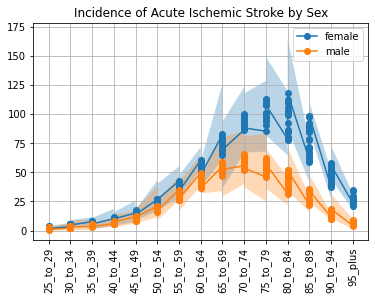

In [47]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [48]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,40,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,27309.448323
1,41,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,27655.797399
2,42,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,27492.052019
3,43,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,27315.197810
4,44,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,27282.234086


In [49]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000152,0.000073,0.000302
1,25_to_29,female,2024,0.000143,0.000036,0.000326
2,25_to_29,female,2025,0.000118,0.000037,0.000242
3,25_to_29,female,2026,0.000112,0.000008,0.000245
4,25_to_29,female,2027,0.000104,0.000000,0.000215


In [50]:
%%capture
with PdfPages('model4vv_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [51]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000595  0.000303  0.001133
                2024  0.000671  0.000334  0.001374
                2025  0.000640  0.000268  0.001151
                2026  0.000614  0.000434  0.000774
                2027  0.000578  0.000249  0.000862

In [52]:
%%capture
with PdfPages('model4vv_acute_MI_inc.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Angina 

In [53]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(['angina_susceptible_to_angina'])].reset_index() 
tran_rate_angina = tran.loc[(tran['transition'].isin(['angina_susceptible_to_angina_to_angina']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000065  0.000036  0.000109
                2024  0.000084  0.000000  0.000240
                2025  0.000082  0.000037  0.000169
                2026  0.000056  0.000008  0.000112
                2027  0.000082  0.000008  0.000149

In [54]:
%%capture
with PdfPages('model4vv_angina_inc.pdf') as pdf:
    for sex in tran_angina_summ.index.get_level_values('sex').unique():
        for year in tran_angina_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex) & (tran_angina_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [55]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  washington.hdf


In [56]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [57]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [58]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [59]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [60]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [61]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [62]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001160,0.000720,0.001653
1,25_to_29,male,0.002432,0.001787,0.003236
2,30_to_34,female,0.001553,0.000946,0.002110
3,30_to_34,male,0.002706,0.002003,0.003465
4,35_to_39,female,0.001834,0.001291,0.002384


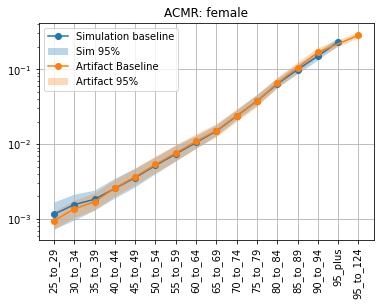

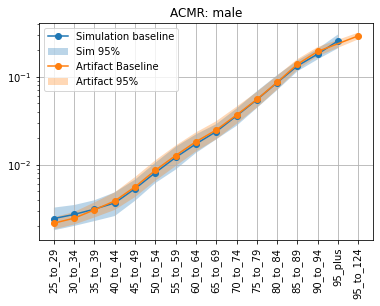

In [63]:
with PdfPages('model4vv_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [64]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [65]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [66]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [67]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [68]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000003,0.0,0.000039
1,25_to_29,male,0.000004,0.0,0.000038
2,30_to_34,female,0.000005,0.0,0.000057
3,30_to_34,male,0.000005,0.0,0.000038
4,35_to_39,female,0.000007,0.0,0.000039


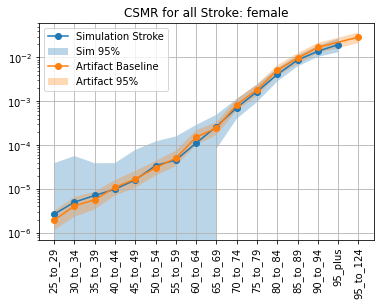

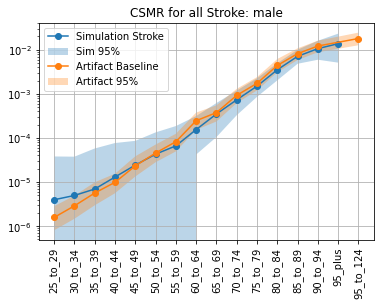

In [69]:
with PdfPages('model4vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Myocardial Infarction

In [70]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000017,0.000012,0.000024,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000047,0.000034,0.000064,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000098,0.000072,0.000132,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000232,0.000165,0.000311,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000393,0.000291,0.000513,Alabama,cause_specific_mortality_rate,45_to_49


In [71]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [72]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

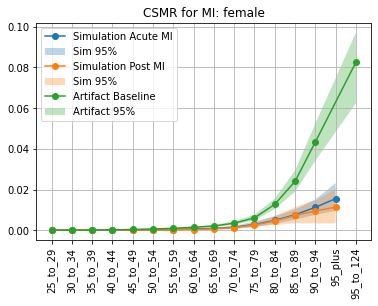

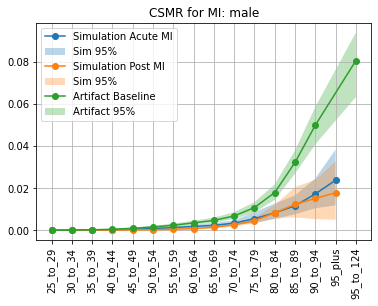

In [73]:
with PdfPages('model4vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_rate_allyear.loc[(acute_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = post_MI_rate_allyear.loc[(post_MI_rate_allyear.sex==sex)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Acute MI', 'Sim 95%', 'Simulation Post MI', 'Sim 95%','Artifact Baseline', 'Artifact 95%']) 

In [74]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000188,0.000038,0.000381
1,25_to_29,male,0.000232,0.000073,0.000464
2,30_to_34,female,0.000173,0.000036,0.000376
3,30_to_34,male,0.000246,0.000054,0.000453
4,35_to_39,female,0.000138,0.000036,0.000305


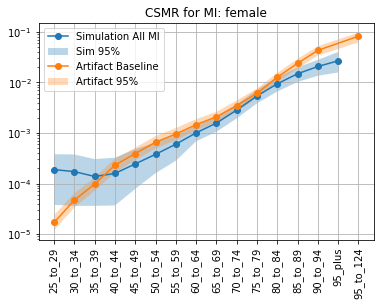

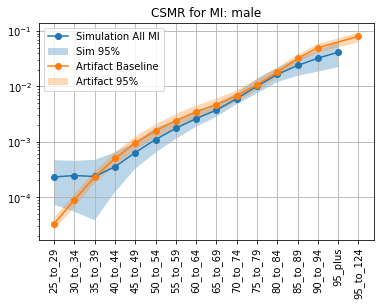

In [75]:
for sex in total_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = total_MI_rate_allyear.loc[(total_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [76]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [77]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000115,0.000000,0.000320
1,25_to_29,male,0.000075,0.000000,0.000264
2,30_to_34,female,0.000175,0.000017,0.000449
3,30_to_34,male,0.000108,0.000000,0.000301
4,35_to_39,female,0.000253,0.000038,0.000566


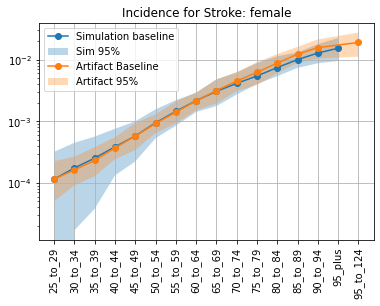

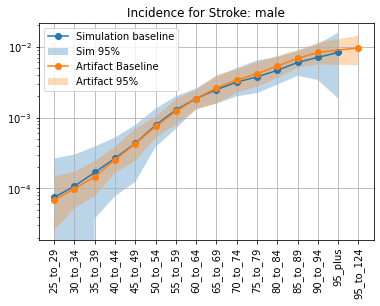

In [78]:
with PdfPages('model4vv_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [79]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [80]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000577  0.000361  0.000881
         male    0.000582  0.000364  0.000920
30_to_34 female  0.000589  0.000392  0.000857
         male    0.000726  0.000502  0.001030
35_to_39 female  0.000494  0.000383  0.000656

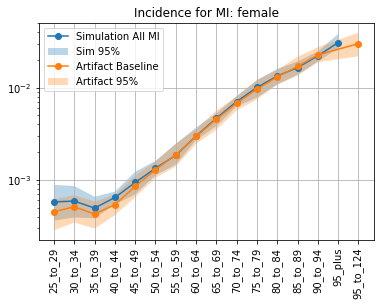

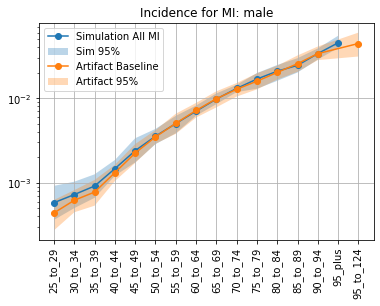

In [81]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina

In [82]:
art_inc_angina = load_artifact_data('cause', 'angina', 'incidence_rate')
art_inc_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_angina.age_start, art_inc_angina.age_end)]
art_inc_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000061,0.000042,0.000082,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000088,0.000060,0.000121,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000115,0.000075,0.000160,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000149,0.000109,0.000193,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000189,0.000108,0.000289,Alabama,incidence_rate,45_to_49


In [83]:
groupby_cols = ['age', 'sex']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000078  0.000078  0.000078
         male    0.000118  0.000118  0.000118
30_to_34 female  0.000102  0.000102  0.000102
         male    0.000143  0.000143  0.000143
35_to_39 female  0.000132  0.000132  0.000132

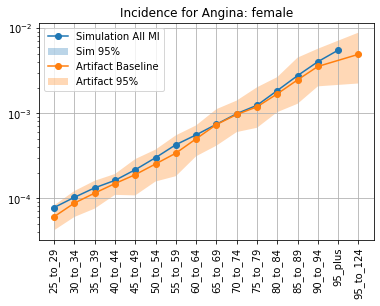

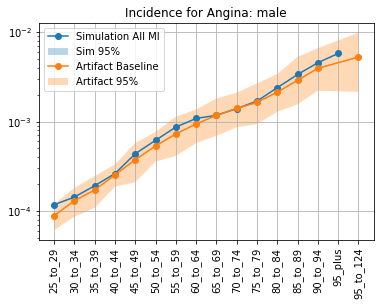

In [84]:
for sex in tran_angina_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_angina.loc[(art_inc_angina.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence Rates

In [85]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [86]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


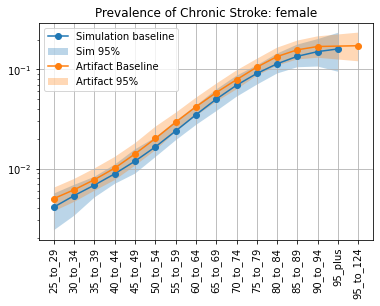

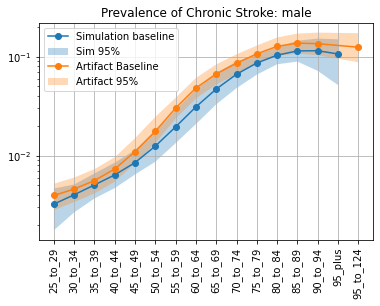

In [87]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [88]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [89]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

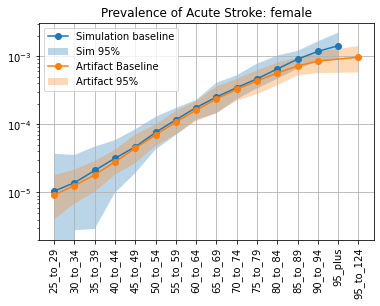

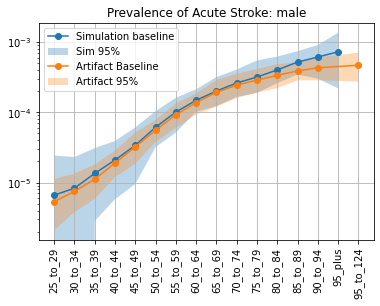

In [90]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [91]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [92]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001615,0.001075,0.002225
1,25_to_29,male,0.001352,0.000873,0.002079
2,30_to_34,female,0.003171,0.002050,0.004869
3,30_to_34,male,0.003051,0.001961,0.004832
4,35_to_39,female,0.004851,0.003687,0.006950


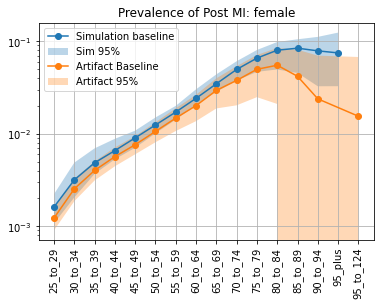

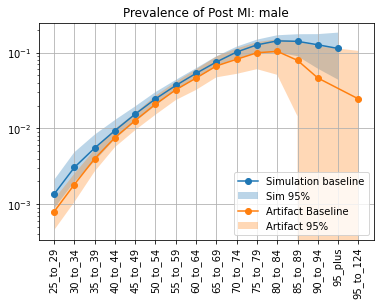

In [93]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Acute MI

In [94]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [95]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000044,0.000014,0.000083
1,25_to_29,male,0.000044,0.000014,0.000082
2,30_to_34,female,0.000045,0.000020,0.000078
3,30_to_34,male,0.000056,0.000025,0.000098
4,35_to_39,female,0.000038,0.000017,0.000066


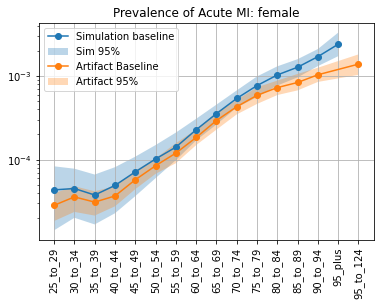

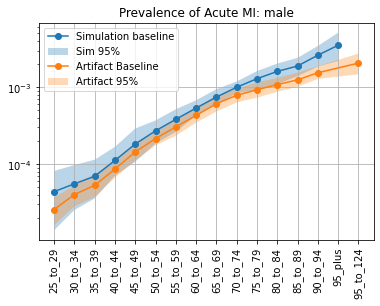

In [96]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina

In [97]:
art_prev_angina = load_artifact_data('cause', 'angina', 'prevalence')
art_prev_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_angina.age_start,art_prev_angina.age_end)]
art_prev_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000141,0.000093,0.000197,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000289,0.000198,0.000390,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000574,0.000381,0.000790,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.001131,0.000791,0.001517,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.001916,0.001455,0.002449,Alabama,prevalence,45_to_49


In [98]:
prev_angina_sum_allyear = (prev_angina
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000147,0.000013,0.000322
1,25_to_29,male,0.000211,0.000042,0.000458
2,30_to_34,female,0.000346,0.000144,0.000613
3,30_to_34,male,0.000423,0.000174,0.000834
4,35_to_39,female,0.000671,0.000391,0.001105


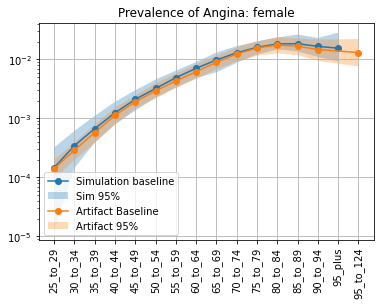

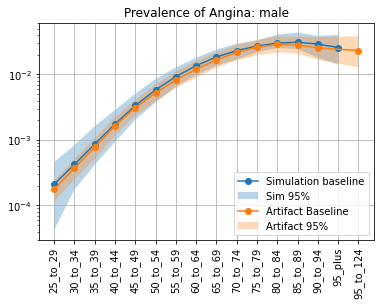

In [99]:
for sex in prev_angina_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_angina_sum_allyear.loc[(prev_angina_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_angina.loc[(art_prev_angina.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Excess Mortality Rate

#### Acute Stroke

In [100]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [101]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.303448,0.0,2.657846
1,25_to_29,male,0.533049,0.0,6.522321
2,30_to_34,female,0.346107,0.0,3.940569
3,30_to_34,male,0.710298,0.0,6.522321
4,35_to_39,female,0.287948,0.0,3.148274


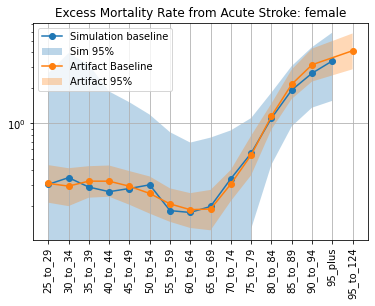

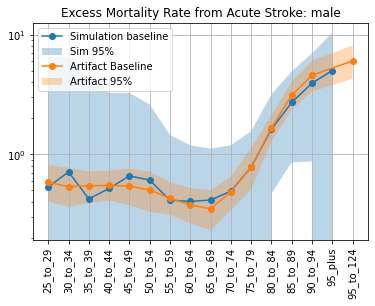

In [102]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [103]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [104]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000000,0.0,0.000000
1,25_to_29,male,0.000000,0.0,0.000000
2,30_to_34,female,0.000043,0.0,0.000000
3,30_to_34,male,0.000131,0.0,0.000000
4,35_to_39,female,0.000148,0.0,0.002546


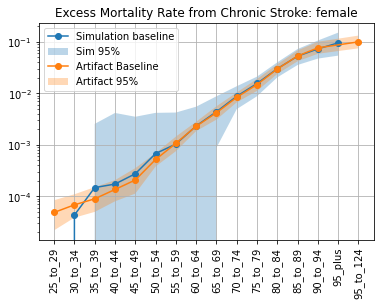

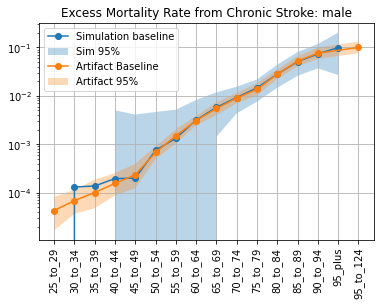

In [105]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [106]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [107]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.887978,0.000000,6.522321
1,25_to_29,male,3.487666,0.281646,6.522321
2,30_to_34,female,2.245252,0.000000,5.816334
3,30_to_34,male,2.847991,0.686656,5.404894
4,35_to_39,female,1.730223,0.000000,5.062952


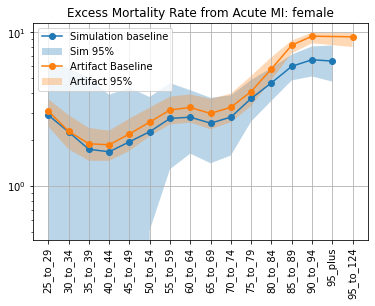

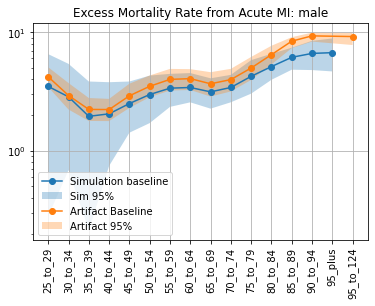

In [108]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [109]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.042968,0.0,0.109224
1,25_to_29,male,0.059706,0.0,0.142174
2,30_to_34,female,0.023132,0.0,0.058688
3,30_to_34,male,0.028371,0.0,0.069867
4,35_to_39,female,0.014865,0.0,0.036298


In [110]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

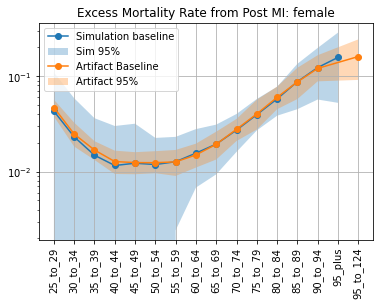

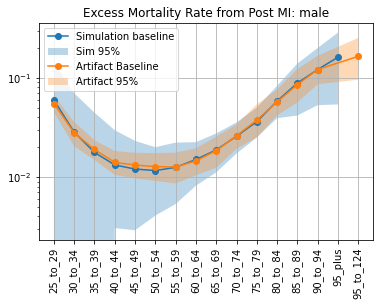

In [111]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Angina EMR

In [112]:
art_emr_angina = load_artifact_data('cause', 'angina', 'excess_mortality_rate')
art_emr_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_angina.age_start,art_emr_angina.age_end)]
art_emr_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.282008,0.206508,0.368893,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.173751,0.129001,0.225407,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.065495,0.050426,0.083836,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.009768,0.005119,0.016087,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.006571,0.003868,0.010055,Alabama,excess_mortality_rate,45_to_49


In [113]:
angina_emr = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
angina_death_cause = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_emr_rate = pd.concat([angina_death_cause, angina_emr.ptvalue], axis=1)
angina_emr_rate['mean_rate'] = angina_emr_rate['value'] / angina_emr_rate['ptvalue']
angina_emr_rate_allyear = (angina_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


angina_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.325955,0.0,1.187488
1,25_to_29,male,0.376941,0.0,1.274959
2,30_to_34,female,0.161366,0.0,0.507452
3,30_to_34,male,0.233054,0.0,0.637595
4,35_to_39,female,0.067439,0.0,0.237921


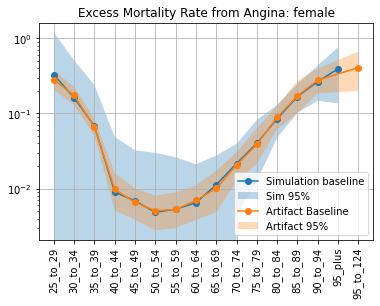

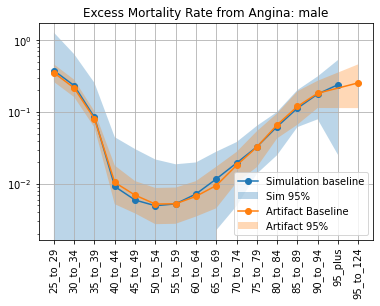

In [114]:
for sex in angina_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = angina_emr_rate_allyear.loc[(angina_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_angina.loc[(art_emr_angina.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

# GBD Comparison

#### All Cause Mortality Rate

In [115]:
from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws


In [116]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [117]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,1,3,1,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002153,0.002516,0.001834,25_to_29
1,10,294,523,1,3,2,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.000950,0.001237,0.000706,25_to_29
2,11,294,523,1,3,1,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002456,0.002887,0.002079,30_to_34
3,11,294,523,1,3,2,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001364,0.001755,0.001029,30_to_34
4,12,294,523,1,3,1,2019,_all,35 to 39,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.003056,0.003710,0.002501,35_to_39


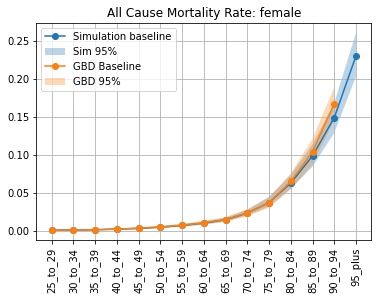

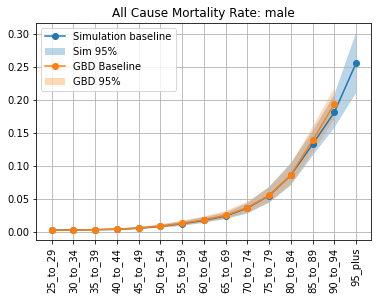

In [118]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### CSMR for IHD

In [119]:
gbd_csmr_ihd = go("cause", gbd_round_id=6, 
              age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], 
              cause_id=493, 
              measure_id=1, 
              metric_id=3, 
              location_id=523, 
              year_id=2019, 
              sex_id=[1,2], 
              decomp_step='step5')
gbd_csmr_ihd['age'] = gbd_csmr_ihd.age_group_name.str.replace(' ', '_')
#gbd_csmr_ihd.head()

In [120]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate.head()

,index,age,sex,year,input_draw,cause,value,ptvalue,mean_rate
0,2,25_to_29,female,2023,29,angina,2,27465.374401,0.000073
1,8,25_to_29,female,2023,232,angina,1,27790.258727,0.000036
2,14,25_to_29,female,2023,357,angina,0,27624.366872,0.000000
3,20,25_to_29,female,2023,394,angina,1,27459.318275,0.000036
4,26,25_to_29,female,2023,602,angina,0,27431.260780,0.000000


In [176]:
#total_MI_rate.head()

In [121]:
total_MI_rate = total_MI_rate.rename(columns = {'total_rate':'mi_total_rate'})
angina_rate = angina_rate.rename(columns = {'mean_rate':'angina_rate'})
ihd_rate = pd.concat([total_MI_rate, angina_rate.angina_rate], axis=1)
ihd_rate['total_rate'] = ihd_rate['mi_total_rate'] + ihd_rate['angina_rate']
ihd_rate.head()

,index,age,sex,year,input_draw,cause,value,ptvalue,acute_rate,post_rate,mi_total_rate,angina_rate,total_rate
0,1,25_to_29,female,2023,29,acute_myocardial_infarction,2,27465.374401,0.000073,0.000036,0.000109,0.000073,0.000182
1,7,25_to_29,female,2023,232,acute_myocardial_infarction,5,27790.258727,0.000180,0.000036,0.000216,0.000036,0.000252
2,13,25_to_29,female,2023,357,acute_myocardial_infarction,1,27624.366872,0.000036,0.000109,0.000145,0.000000,0.000145
3,19,25_to_29,female,2023,394,acute_myocardial_infarction,3,27459.318275,0.000109,0.000073,0.000182,0.000036,0.000219
4,25,25_to_29,female,2023,602,acute_myocardial_infarction,2,27431.260780,0.000073,0.000000,0.000073,0.000000,0.000073


In [122]:
ihd_rate_allyear = (ihd_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
#ihd_rate_allyear.head()

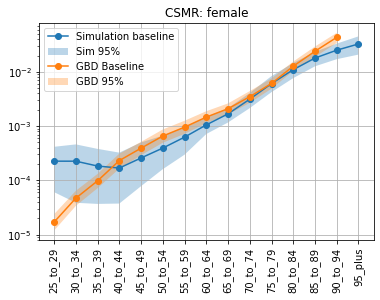

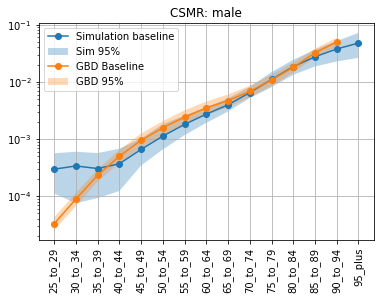

In [123]:
for sex in ihd_rate_allyear.sex.unique():
    plt.figure() 
    subdata = ihd_rate_allyear.loc[(ihd_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_csmr_ihd.loc[(gbd_csmr_ihd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'CSMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [124]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [125]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,6,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000068,0.000147,0.000025,25_to_29
1,10,495,523,6,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000115,0.000224,0.000050,25_to_29
2,11,495,523,6,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000098,0.000171,0.000052,30_to_34
3,11,495,523,6,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000162,0.000265,0.000091,30_to_34
4,12,495,523,6,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000145,0.000243,0.000077,35_to_39


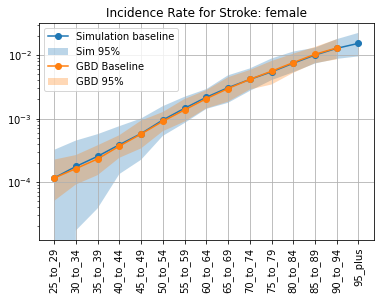

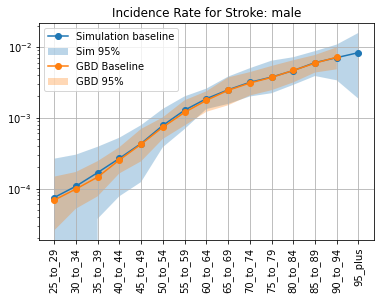

In [126]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [127]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,6,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000441,0.000626,0.000274,25_to_29
1,10,493,523,6,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000452,0.000616,0.000284,25_to_29
2,11,493,523,6,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000621,0.000818,0.000448,30_to_34
3,11,493,523,6,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000510,0.000683,0.000345,30_to_34
4,12,493,523,6,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000777,0.001081,0.000536,35_to_39


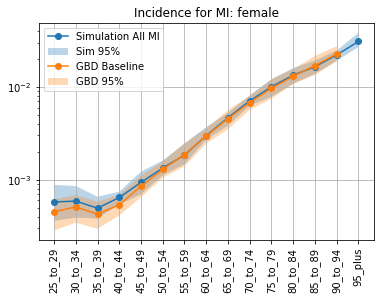

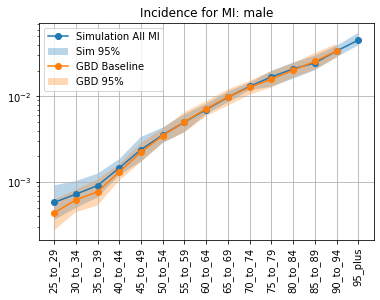

In [128]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [129]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000570,0.000184,0.001146
1,25_to_29,male,0.000580,0.000225,0.001061
2,30_to_34,female,0.000588,0.000262,0.001019
3,30_to_34,male,0.000726,0.000301,0.001260
4,35_to_39,female,0.000494,0.000227,0.000840


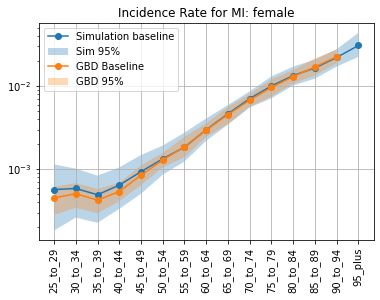

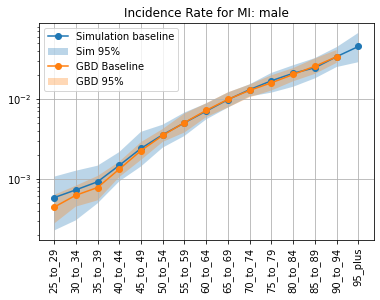

In [130]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Incidence for Angina

In [131]:
angina_inc = get_draws('modelable_entity_id',
                1817,
                source='epi',
                location_id=523,
                age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
                sex_id=[1,2],
                measure_id = 6,
                year_id=2019,
                gbd_round_id=6,
                 decomp_step='step4')
angina_inc['age_group'] = np.where(angina_inc['age_group_id']==10,'25_to_29',np.where(angina_inc['age_group_id']==11,'30_to_34',np.where(angina_inc['age_group_id']==12,'35_to_39',np.where(angina_inc['age_group_id']==13,'40_to_44',np.where(angina_inc['age_group_id']==14,'45_to_49',np.where(angina_inc['age_group_id']==15,'50_to_54',np.where(angina_inc['age_group_id']==16,'55_to_59',np.where(angina_inc['age_group_id']==17,'60_to_64',np.where(angina_inc['age_group_id']==18,'65_to_69',np.where(angina_inc['age_group_id']==19,'70_to_74',np.where(angina_inc['age_group_id']==20,'75_to_79',np.where(angina_inc['age_group_id']==30,'80_to_84',np.where(angina_inc['age_group_id']==31,'85_to_89',np.where(angina_inc['age_group_id']==32,'90_to_94',np.where(angina_inc['age_group_id']==33,'95_to_100',0)))))))))))))))
angina_inc['sex'] = np.where(angina_inc['sex_id']==1,'Male','Female')
mean_df = angina_inc.iloc[:,1:1001]
angina_inc['mean'] = mean_df.mean(axis=1)
angina_inc = angina_inc.sort_values(by=['age_group'])
#angina_inc

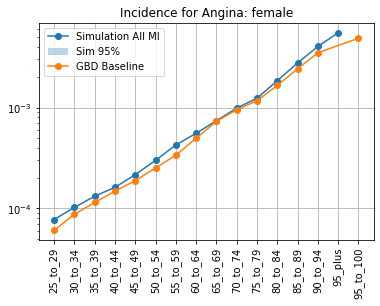

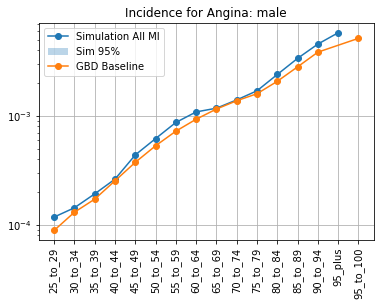

In [132]:
for sex in tran_angina_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = angina_inc.loc[(angina_inc.sex==sex.capitalize())]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.title(f'Incidence for Angina: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline']) 

#### DALYs from Stroke

In [171]:
gbd_daly = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [172]:
gbd_daly['age'] = gbd_daly.age_group_name.str.replace(' ', '_')
gbd_daly.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,2,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000573,0.000875,0.000337,25_to_29
1,10,495,523,2,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.000837,0.001272,0.000515,25_to_29
2,11,495,523,2,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000723,0.001057,0.000457,30_to_34
3,11,495,523,2,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001110,0.001578,0.000720,30_to_34
4,12,495,523,2,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.000972,0.001417,0.000638,35_to_39


In [173]:
yll_stroke = yll.loc[yll['cause'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld.loc[yld['cause_of_disability'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke"])].reset_index()
yld_stroke = yld_stroke.rename(columns = {'cause_of_disability':'cause'})
yld_stroke

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,cause,yld
0,0,0,female,2023,ylds,29,baseline,25_to_29,acute_ischemic_stroke,0.000369
1,1,1,female,2023,ylds,29,baseline,30_to_34,acute_ischemic_stroke,0.000175
2,2,2,female,2023,ylds,29,baseline,35_to_39,acute_ischemic_stroke,0.000476
3,3,3,female,2023,ylds,29,baseline,40_to_44,acute_ischemic_stroke,0.000612
...,...,...,...,...,...,...,...,...,...,...
10796,21596,21596,male,2040,ylds,946,baseline,80_to_84,chronic_ischemic_stroke,202.187433
10797,21597,21597,male,2040,ylds,946,baseline,85_to_89,chronic_ischemic_stroke,135.849919
10798,21598,21598,male,2040,ylds,946,baseline,90_to_94,chronic_ischemic_stroke,50.250355
10799,21599,21599,male,2040,ylds,946,baseline,95_plus,chronic_ischemic_stroke,17.274765


In [177]:
daly_stroke = yll_stroke.merge(yld_stroke[['yld','sex','age','year','cause', 'input_draw']], on=['sex','age','year','cause', 'input_draw'])
daly_stroke['daly'] = daly_stroke['yll'] + daly_stroke['yld']
daly_stroke.head()

,index,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,yll,yld,daly
0,0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,0.000000,0.000369,0.000369
1,1,1,female,2023,acute_ischemic_stroke,ylls,29,baseline,30_to_34,0.000000,0.000175,0.000175
2,2,2,female,2023,acute_ischemic_stroke,ylls,29,baseline,35_to_39,0.000000,0.000476,0.000476
3,3,3,female,2023,acute_ischemic_stroke,ylls,29,baseline,40_to_44,0.000000,0.000612,0.000612
4,4,4,female,2023,acute_ischemic_stroke,ylls,29,baseline,45_to_49,42.888177,0.001134,42.889311


In [178]:
daly_stroke = daly_stroke.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_stroke_rate = pd.concat([daly_stroke, per_time_group.ptvalue], axis=1)
daly_stroke_rate['daly_rate'] = daly_stroke_rate['daly'] / daly_stroke_rate['ptvalue']
daly_stroke_sum_allyear = (daly_stroke_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_stroke_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000856,0.000367,0.003132
1,25_to_29,male,0.000701,0.000250,0.002899
2,30_to_34,female,0.001191,0.000534,0.004090
3,30_to_34,male,0.000851,0.000355,0.002841
4,35_to_39,female,0.001510,0.000770,0.003411


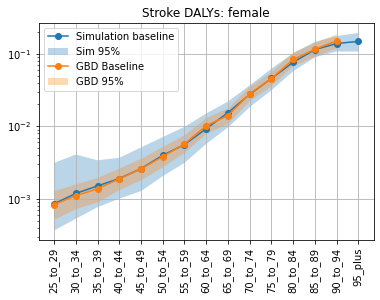

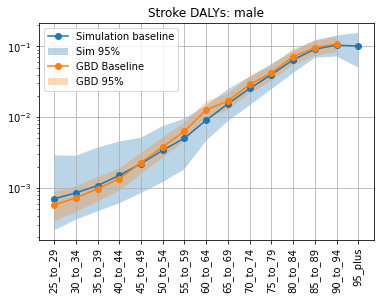

In [179]:
for sex in daly_stroke_sum_allyear.sex.unique():
    plt.figure() 
    subdata = daly_stroke_sum_allyear.loc[(daly_stroke_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly.loc[(gbd_daly.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Stroke DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [139]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [140]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,2,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.002084,0.002684,0.001595,25_to_29
1,10,493,523,2,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001076,0.001488,0.000753,25_to_29
2,11,493,523,2,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.005151,0.006505,0.003896,30_to_34
3,11,493,523,2,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.002720,0.003687,0.001977,30_to_34
4,12,493,523,2,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.012157,0.015460,0.009483,35_to_39


In [141]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [142]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

,age,sex,year,input_draw,yll,yld,daly
0,25_to_29,female,2023,29,189.634584,0.061202,189.695786
1,25_to_29,female,2023,232,379.586161,0.131147,379.717308
2,25_to_29,female,2023,357,244.501919,0.078688,244.580607
3,25_to_29,female,2023,394,307.947890,0.183606,308.131496
4,25_to_29,female,2023,602,120.968126,0.218579,121.186705


In [143]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.011644,0.002415,0.023621
1,25_to_29,male,0.014307,0.004534,0.028593
2,30_to_34,female,0.009795,0.002112,0.021456
3,30_to_34,male,0.013924,0.003059,0.025647
4,35_to_39,female,0.007167,0.001854,0.015791


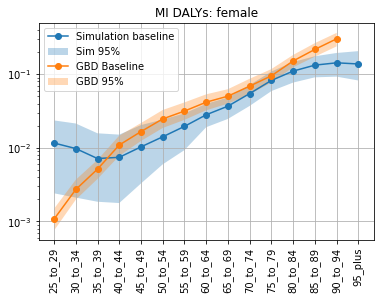

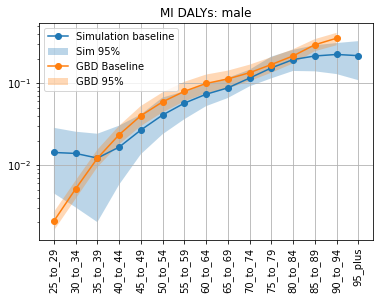

In [144]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### LDL-C Testing - Total Exposure by age/year

In [145]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
ldl = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,25_to_29,75994.118265
1,1,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,30_to_34,75660.614844
2,2,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,35_to_39,74173.523757
3,3,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,40_to_44,74285.075358
4,4,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,45_to_49,71912.919940


In [146]:
ldl_summ = (ldl
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#ldl_summ

In [147]:
%%capture
for sex in ldl_summ.sex.unique():
    for year in ldl_summ.year.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.ylim(0,100000)
        plt.grid()

In [148]:
%%capture
for sex in ldl_summ.sex.unique():
    for age in ldl_summ.age.unique():
        plt.figure() 
        subdata = ldl_summ.loc[(ldl_summ.sex==sex) & (ldl_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

The absolute number is definitely changing over time. Let's see if this is due to changes in population structure or something else. 

### Rates of Exposure by Age/Year

In [149]:
ldl_rate = ldl.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_rate = pd.concat([ldl_rate, per_time_group.ptvalue], axis=1)
ldl_rate['ldl_rate'] = ldl_rate['value'] / ldl_rate['ptvalue']
ldl_rate_summ = (ldl_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.810857,2.577462,3.078990
1,25_to_29,female,2024,2.810656,2.578005,3.076316
2,25_to_29,female,2025,2.810275,2.579952,3.074719
3,25_to_29,female,2026,2.810685,2.579860,3.073205
4,25_to_29,female,2027,2.810558,2.580034,3.072224


In [153]:
## Want to think through these. These are now rates - why is it dropping at older age groups? Selection bias 
## (those with high cholestrol don't live as long?) Something else? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for year in ldl_rate_summ.year.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [155]:
## These look a bit funny - we should discuss. What is causing changes over time across these groups? 
## Why is this not 3? 

%%capture
for sex in ldl_rate_summ.sex.unique():
    for age in ldl_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

UsageError: Line magic function `%%capture` not found.


### Within 2023, LDL-C Distribution 

In [156]:
ldl_2023 = ldl.loc[ldl['year']==2023].reset_index()
ldl_2023.head()

,index,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,0,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,25_to_29,75994.118265
1,1,1,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,30_to_34,75660.614844
2,2,2,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,35_to_39,74173.523757
3,3,3,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,40_to_44,74285.075358
4,4,4,female,2023,high_ldl_cholesterol,risk_exposure_time,29,baseline,45_to_49,71912.919940


### Compare with Artifact 
'risk_factor.high_ldl_cholesterol.distribution' - just says "ensemble"

'risk_factor.high_ldl_cholesterol.exposure'

'risk_factor.high_ldl_cholesterol.exposure_standard_deviation'

'risk_factor.high_ldl_cholesterol.exposure_distribution_weights'- weights of the ensemble dist

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

'risk_factor.high_ldl_cholesterol.tmred' - GBD values, no testing

'risk_factor.high_ldl_cholesterol.relative_risk_scalar' - this is just 1

In [157]:
ldl_exp = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp.age_start,ldl_exp.age_end)]
ldl_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.805110,2.597516,3.051877,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.790157,2.588387,2.991761,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.855153,2.640309,3.069596,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.864634,2.652549,3.073091,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.994765,2.785903,3.219201,Alabama,exposure,45_to_49


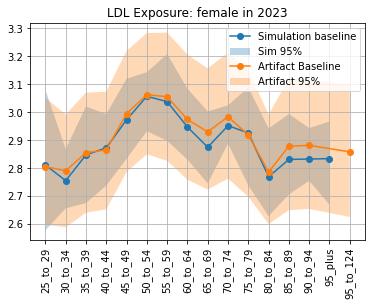

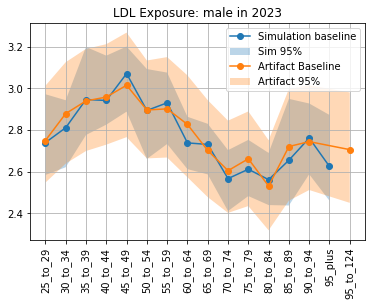

In [158]:
for sex in ldl_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_rate_summ.loc[(ldl_rate_summ.sex==sex) & (ldl_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_exp.loc[(ldl_exp.sex==sex) & (ldl_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### High SBP Risk Factor Testing 

In [159]:
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
150,150,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,25_to_29,3.212863e+06
151,151,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,30_to_34,3.390452e+06
152,152,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,35_to_39,2.869427e+06
153,153,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,40_to_44,3.158538e+06
154,154,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,45_to_49,2.931732e+06


In [160]:
sbp_summ = (sbp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
#sbp_summ

In [163]:
%%capture
for sex in sbp_summ.sex.unique():
    for year in sbp_summ.year.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [164]:
#Some interesting patterns going on here - since it is not a rate I am not overly concerned but might be worth a look
%%capture
for sex in sbp_summ.sex.unique():
    for age in sbp_summ.age.unique():
        plt.figure() 
        subdata = sbp_summ.loc[(sbp_summ.sex==sex) & (sbp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

UsageError: Line magic function `%%capture` not found.


In [166]:
sbp_rate = sbp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_rate = pd.concat([sbp_rate, per_time_group.ptvalue], axis=1)
sbp_rate['ldl_rate'] = sbp_rate['value'] / sbp_rate['ptvalue']
sbp_rate_summ = (sbp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,114.616654,106.538523,120.555798
1,25_to_29,female,2024,114.614056,106.557056,120.578301
2,25_to_29,female,2025,114.617399,106.547092,120.580579
3,25_to_29,female,2026,114.625051,106.589462,120.584837
4,25_to_29,female,2027,114.633721,106.615996,120.611219


In [167]:
%%capture
for sex in sbp_rate_summ.sex.unique():
    for year in sbp_rate_summ.year.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [168]:
%%capture
for sex in sbp_rate_summ.sex.unique():
    for age in sbp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [169]:
sbp_exp = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_exp['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp.age_start,sbp_exp.age_end)]
sbp_exp.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,114.500732,101.716393,127.389503,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,113.207856,100.753767,126.385370,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,115.716469,103.617384,128.913762,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,118.712085,105.661678,133.771730,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,123.960399,110.054265,139.549595,Alabama,exposure,45_to_49


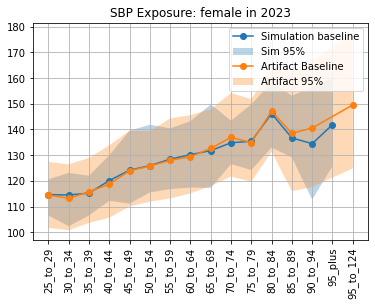

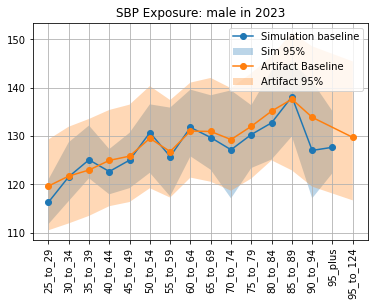

In [170]:
for sex in sbp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_rate_summ.loc[(sbp_rate_summ.sex==sex) & (sbp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_exp.loc[(sbp_exp.sex==sex) & (sbp_exp.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Healthcare Appointments

### Background Visits Match with Artfifact

In [180]:
visits = pd.read_csv(sim_results_dir + 'healthcare_visits.csv')
visits.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,visit_type,value
0,0,female,2023,healthcare_visits,29,baseline,25_to_29,background,66032
1,1,female,2023,healthcare_visits,29,baseline,30_to_34,background,77638
2,2,female,2023,healthcare_visits,29,baseline,35_to_39,background,85107
3,3,female,2023,healthcare_visits,29,baseline,40_to_44,background,67579
4,4,female,2023,healthcare_visits,29,baseline,45_to_49,background,64837


In [187]:
screening_art = load_artifact_data('healthcare_entity', 'outpatient_visits', 'outpatient_envelope')
screening_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(screening_art.age_start,screening_art.age_end)]
screening_art.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,2.639679,1.660388,4.076512,Alabama,outpatient_envelope,25_to_29
1,female,30.0,35.0,2019,2020,2.903855,1.787758,4.386895,Alabama,outpatient_envelope,30_to_34
2,female,35.0,40.0,2019,2020,3.165061,1.993188,4.815238,Alabama,outpatient_envelope,35_to_39
3,female,40.0,45.0,2019,2020,3.527738,2.254962,5.141563,Alabama,outpatient_envelope,40_to_44
4,female,45.0,50.0,2019,2020,3.905085,2.416913,5.692975,Alabama,outpatient_envelope,45_to_49


In [203]:
screen = visits.loc[visits['visit_type']=='background'].reset_index()
screen_rate = screen.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
screen_rate['screen_rate'] = screen_rate['value'] / screen_rate['ptvalue']
screen_rate_summ = (screen_rate
                .groupby(['age', 'sex', 'year'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.187679,1.690312,2.796658
1,25_to_29,female,2024,2.186008,1.681762,2.793636
2,25_to_29,female,2025,2.186040,1.684850,2.793952
3,25_to_29,female,2026,2.191545,1.687635,2.810398
...,...,...,...,...,...,...
536,95_plus,male,2037,5.322593,4.143022,6.732785
537,95_plus,male,2038,5.320083,4.198568,6.712374
538,95_plus,male,2039,5.294076,4.133053,6.676633
539,95_plus,male,2040,5.334219,4.249724,6.726093


In [207]:
%%capture
for sex in screen_rate_summ.sex.unique():
    for year in screen_rate_summ.year.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Screening Visits: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [208]:
%%capture
for sex in screen_rate_summ.sex.unique():
    for age in screen_rate_summ.age.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Screening Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

Since the year over year is looking better than I expected, I think sum over years and compare with the artifact

In [209]:
screen_rate_summ_allyear = (screen_rate
                .groupby(['age', 'sex'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.190016,1.643385,2.868145
1,25_to_29,male,1.195409,0.929504,1.479752
2,30_to_34,female,2.488923,2.017235,2.931672
3,30_to_34,male,1.425979,1.089507,1.619740
...,...,...,...,...,...
26,90_to_94,female,3.980156,3.546771,5.029094
27,90_to_94,male,4.042697,3.509335,5.397616
28,95_plus,female,5.361421,4.035308,7.029858
29,95_plus,male,5.321072,4.108149,7.008099


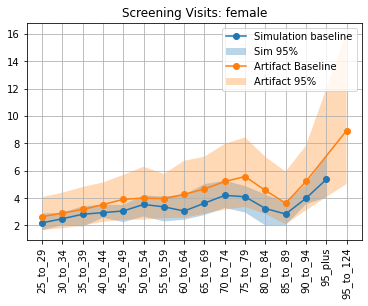

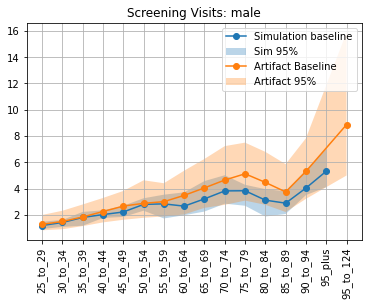

In [216]:
for sex in screen_rate_summ_allyear.sex.unique():
    plt.figure() 
    subdata = screen_rate_summ_allyear.loc[(screen_rate_summ_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

In [217]:
screen_rate_2023 = screen_rate_summ.loc[screen_rate_summ['year']==2023].reset_index()

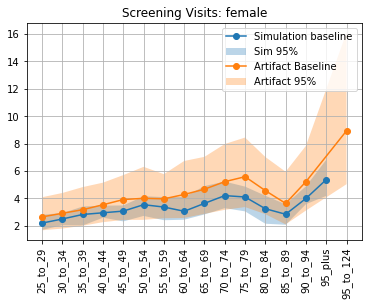

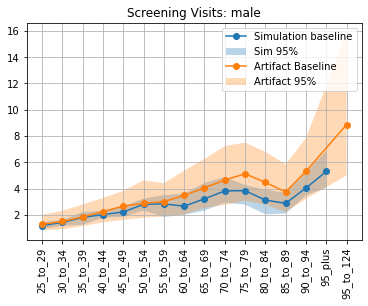

In [218]:
for sex in screen_rate_2023.sex.unique():
    plt.figure() 
    subdata = screen_rate_2023.loc[(screen_rate_2023.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

### Emergency Visits Match Incidence

In [225]:
emg = visits.loc[visits['visit_type']=='emergency'].reset_index()
emg_rate = emg.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
emg_rate['emg_rate'] = emg_rate['value'] / emg_rate['ptvalue']
emg_rate_summ = (emg_rate
                .groupby(['age', 'sex', 'year'])
                .emg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
emg_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000744,0.000498,0.001326
1,25_to_29,female,2024,0.000806,0.000457,0.001546
2,25_to_29,female,2025,0.000762,0.000355,0.001233
3,25_to_29,female,2026,0.000737,0.000545,0.000850
...,...,...,...,...,...,...
536,95_plus,male,2037,0.054743,0.042589,0.066727
537,95_plus,male,2038,0.056382,0.044792,0.074940
538,95_plus,male,2039,0.051498,0.037628,0.062147
539,95_plus,male,2040,0.052465,0.042337,0.071603


In [226]:
inc_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
inc_rate = inc_rate.loc[(inc_rate['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke']))].reset_index()
inc_rate = inc_rate.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
inc_rate = pd.concat([inc_rate, per_time_group.ptvalue], axis=1)
inc_rate['rate']= inc_rate['value'] / inc_rate['ptvalue']
inc_rate_summ = (inc_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

inc_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000765,0.000583,0.001333
1,25_to_29,female,2024,0.000836,0.000457,0.001607
2,25_to_29,female,2025,0.000792,0.000355,0.001295
3,25_to_29,female,2026,0.000759,0.000545,0.000920
4,25_to_29,female,2027,0.000698,0.000359,0.001035


In [231]:
%%capture
for sex in emg_rate_summ.sex.unique():
    for year in emg_rate_summ.year.unique():
        plt.figure() 
        subdata = emg_rate_summ.loc[(emg_rate_summ.sex==sex) & (emg_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = inc_rate_summ.loc[(inc_rate_summ.sex==sex) & (inc_rate_summ.year==year)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Emergency Visits Compared with Incidence of MI and Stroke: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.legend(['Emergency Visits baseline', 'Sim 95%', 'Incidence of MI and Stroke', '95%'])
        plt.grid()

### Look at Follow-ups 

In [233]:
followup = visits.loc[visits['visit_type']=='scheduled'].reset_index()
followup_rate = followup.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
followup_rate['followup_rate'] = followup_rate['value'] / followup_rate['ptvalue']
followup_rate_summ = (followup_rate
                .groupby(['age', 'sex', 'year'])
                .followup_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
followup_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,1.860024,1.781190,1.922248
1,25_to_29,female,2024,1.863152,1.791613,1.921942
2,25_to_29,female,2025,1.864226,1.789007,1.923316
3,25_to_29,female,2026,1.861322,1.789894,1.923802
...,...,...,...,...,...,...
536,95_plus,male,2037,1.909347,1.878289,1.937846
537,95_plus,male,2038,1.896701,1.881495,1.906322
538,95_plus,male,2039,1.900977,1.865579,1.925879
539,95_plus,male,2040,1.902380,1.878350,1.921390


In [235]:
%%capture
for sex in followup_rate_summ.sex.unique():
    for year in followup_rate_summ.year.unique():
        plt.figure() 
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Follow-up Visits: {sex} in {year}') 
        plt.xticks(rotation=90) 
        plt.grid()